# Overcoming a Theoretical Limitation of Self-Attention 

Replication of experiments on FIRST language learning from [Overcoming a Theoretical Limitation of Self-Attention  (Chiang and Cholak, 2022)](https://arxiv.org/pdf/2202.12172.pdf).

In [1]:
from src.transformer import FirstTransformer
import torch
import pandas as pd

## Learning FIRST

Define training parameters as in the original paper. Citing from (David Chiang and Peter Cholak, 2020):
> We used `d_model` = 16 for word encodings, self-attention, and FFNN outputs, and `d_FFNN` = 64 for FFNN hidden layers. We used layer normalization (ε = 10^−5) after residual connections. We used PyTorch’s default initialization and trained using Adam (Kingma and Ba, 2015) with learning rate 3 × 10^−4 (Karpathy, 2016). We did not use dropout, as it did not seem to help.

In [2]:
log_sigmoid = torch.nn.LogSigmoid()
alphabet = ["0", "1", "$"]

epochs = 10
layers = 2
heads = 1 
d_model = 16 
d_ffnn = 64  
eps = 1e-5 # value added to denominator in layer normalization

### Generalization experiment

Load training data and convert them to Tensor.

In [3]:
train10 = pd.read_csv("data/first/train_n100_l10.csv")
train30 = pd.read_csv("data/first/train_n100_l30.csv")
train100 = pd.read_csv("data/first/train_n100_l100.csv")
train300 = pd.read_csv("data/first/train_n100_l300.csv")
test = pd.read_csv("data/first/test_n100_l1000.csv")

In [4]:
X_train10, y_train10 = train10['sequence'].values, train10['label'].values
X_train30, y_train30 = train30['sequence'].values, train30['label'].values
X_train100, y_train100 = train100['sequence'].values, train100['label'].values
X_train300, y_train300 = train300['sequence'].values, train300['label'].values
X_test, y_test = test['sequence'].values, test['label'].values

In [5]:
alphabet_index = {a:i for i,a in enumerate(alphabet)}

def _encode(s: str) -> torch.Tensor:
    t = torch.tensor([alphabet_index[c] for c in s])
    return t

X_train10 = [_encode(s) for s in X_train10]
X_train30 = [_encode(s) for s in X_train30]
X_train100 = [_encode(s) for s in X_train100]
X_train300 = [_encode(s) for s in X_train300]
X_test = [_encode(s) for s in X_test]

Training cycle.

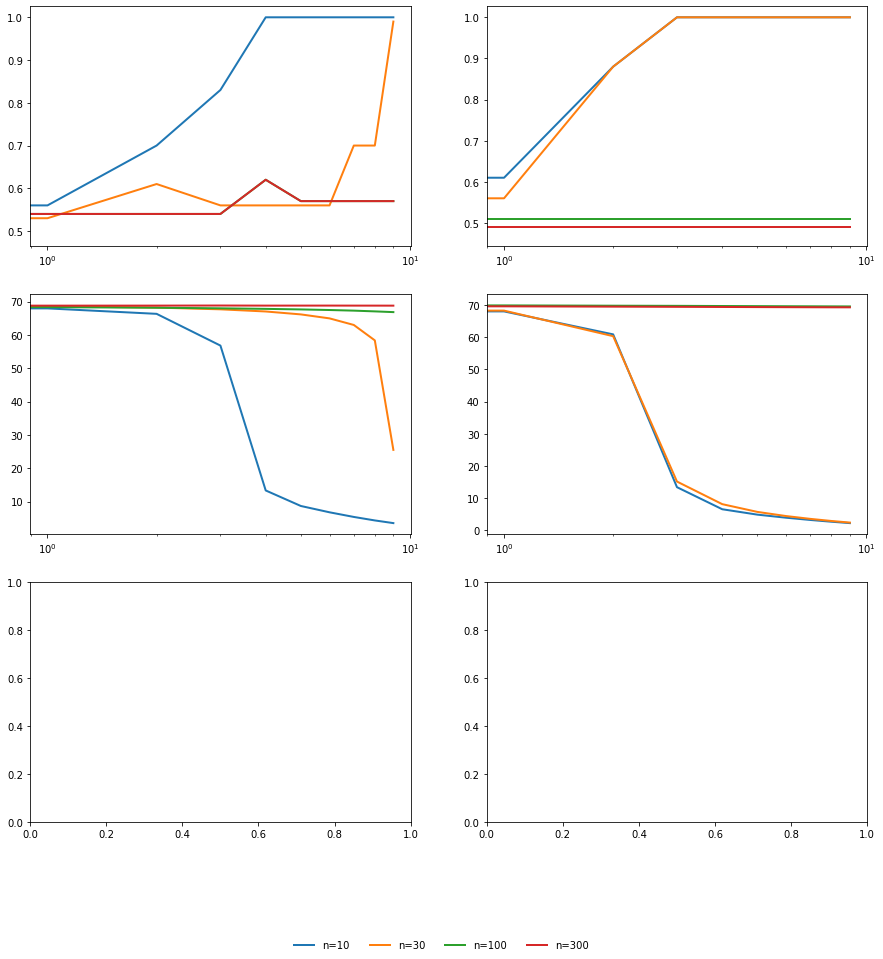

In [7]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
plot = [(ax1, ax3, ax5), (ax2, ax4, ax6)]

for scaled in [False, True]:

    for X_train, y_train, label in [(X_train10, y_train10, "n=10"), (X_train30, y_train30, "n=30"), (X_train100, y_train100, "n=100"), (X_train300, y_train300,"n=300")]:
        
        # plots
        acc_plot, entropy_plot, att_plot = plot[scaled]

        transformer = FirstTransformer(len(alphabet), layers, heads, d_model, d_ffnn, scaled, eps)
        optim = torch.optim.Adam(transformer.parameters(), lr=0.0003)
        
        train_l = []
        val_l = []
        train_acc = []
        val_acc = []

        for epoch in range(epochs):

            train_loss = train_correct = 0    
            
            # train step
            for x, y in zip(X_train, y_train):

                output = transformer(x)

                if not y: output = -output

                if output > 0: train_correct += 1

                loss = -log_sigmoid(output)
                train_loss += loss.item()
                optim.zero_grad()
                loss.backward()
                optim.step()

            # save statistic about training step
            train_l.append(train_loss) # loss
            train_acc.append(train_correct/len(X_train)) # accuracy
                
            # validation step
            with torch.no_grad():

                test_loss = test_correct = 0

                for x, y in zip(X_test, y_test):

                    output = transformer(x)

                    if not y: output = -output

                    if output > 0: test_correct += 1

                    loss = -log_sigmoid(output)
                    test_loss += loss.item()

            # save statistic about validation step
            val_l.append(test_loss) # loss
            val_acc.append(test_correct/len(X_test)) # accuracy

            # print step info
            #print(f"[Epoch {epoch+1}] --> Train acc: {train_correct/len(X_train)} Train loss: {train_loss}, Test acc: {test_correct/len(X_test)} Test loss: {test_loss}", flush=True)

        acc_plot.plot(range(epoch+1), val_acc, lw=2, label=label)   
        acc_plot.set_xscale('log')

        entropy_plot.plot(range(epoch+1), val_l, lw=2, label=label)
        entropy_plot.set_xscale('log')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='lower center',  ncol=4)